In [3]:
from __future__ import print_function
import argparse
import random
import torch
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import numpy as np
from warpctc_pytorch import CTCLoss
import os,inspect
import sys  
stdout = sys.stdout
reload(sys)  
sys.setdefaultencoding('latin-1')
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import utils
import dataset

import models.crnn as crnn


from model_error import cer, wer


#My workaround was that at the top of the script, I import sys, and store sys.stdout in a separate variable, e.g. stdout.
sys.stdout = stdout
print(sys.getdefaultencoding())

latin-1


In [4]:
trainroot = "/home/ubuntu/russell/nephi/data/lmdb/train"
valroot = "/home/ubuntu/russell/nephi/data/lmdb/val"
batchSize = 16
test_batch_size = batchSize
nh = 256                  # size of the LSTM hidden state
imgW = 200
imgH = 64
ngpu = 1
beta1 = 0.5
lr = 0.0001
workers = 10
keep_ratio = True
adam = True
adadelta = False
n_test_disp = 100

alph_file_dylan = "/home/ubuntu/dylan/nephi/alphabet.txt"
alph_file_russell = "/home/ubuntu/russell/nephi/alphabet.txt"
alphabet = '0123456789abcdefghijklmnopqrstuvwxyzB- EÂ¬Ã¼.RSÅ«J/DHA:K¤¿ZLGFNTPCOVWIM<8d>Ä<81><9f>,<93>È³¶'
#0123456789abcdefghijklmnopqrstuvwxyzW VCGū¬.HM,ILAZ:BTÿSER<BC>JFāP<9F>NDKOȳ<B6>
#<A4><8D>()—̈-<84><93>Q<96>/Y<BE>U<>+  # This is what I got from Dylan's file

untrained_crnn_dylan = "/home/ubuntu/dylan/nephi/expr/netCRNN_1_100.pth"
#less trained 29
lesstrained_crnn_dylan = "/home/ubuntu/dylan/nephi/expr/netCRNN_1000_100.pth"
trained_crnn_russell = "/home/ubuntu/russell/nephi/expr/netCRNN_3870_100.pth"
trained_crnn_dylan = "/home/ubuntu/dylan/nephi/expr/netCRNN_3210_100.pth"

In [5]:
manualSeed = random.randint(1, 10000)  # fix seed
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
np.random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  3096


In [6]:
cudnn.benchmark = True
cuda= True

train_dataset = dataset.lmdbDataset(root=trainroot)
assert train_dataset
sampler = dataset.randomSequentialSampler(train_dataset, batchSize)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batchSize, sampler=sampler,
    num_workers=int(workers),
    collate_fn=dataset.alignCollate(imgH=imgH, imgW=imgW, keep_ratio=keep_ratio))

test_dataset = dataset.lmdbDataset(root=valroot)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=test_batch_size, sampler=dataset.randomSequentialSampler(test_dataset, test_batch_size),
    num_workers=int(workers),
    collate_fn=dataset.alignCollate(imgH=imgH, imgW=imgW, keep_ratio=keep_ratio))

In [7]:
# Load in the two alphabets
alphabet_russell = ''
alphabet_dylan = ''

with open(alph_file_russell, 'r') as myfile:
    alphabet_russell = myfile.read()
with open(alph_file_dylan, 'r') as myfile:
    alphabet_dylan = myfile.read()

# Test the dylan ALphabet and model first
alphabet = alphabet_dylan

nclass = len(alphabet) + 1
nc = 1

converter = utils.strLabelConverter(alphabet)
criterion = CTCLoss()

# custom weights initialization called on crnn
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [8]:
crnn = crnn.CRNN(imgH, nc, nclass, nh)
crnn.apply(weights_init)

CRNN (
  (cnn): Sequential (
    (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ReLU (inplace)
    (pooling0): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU (inplace)
    (pooling1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (relu2): ReLU (inplace)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU (inplace)
    (pooling2): MaxPool2d (size=(2, 2), stride=(2, 1), dilation=(1, 1))
    (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (relu4): ReLU (inplace)
    (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), pad

In [9]:
image = torch.FloatTensor(batchSize, 3, imgH, imgH)
text = torch.IntTensor(batchSize * 5)          # RA: I don't understand why the text has this size
length = torch.IntTensor(batchSize)

if cuda:
    crnn.cuda()
    crnn = torch.nn.DataParallel(crnn, device_ids=range(ngpu))
    image = image.cuda()
    criterion = criterion.cuda()

In [10]:
image = Variable(image)
text = Variable(text)
length = Variable(length)

# loss averager
loss_avg = utils.averager()

# setup optimizer
if adam:
    optimizer = optim.Adam(crnn.parameters(), lr=lr,
                           betas=(beta1, 0.999))
elif adadelta:
    optimizer = optim.Adadelta(crnn.parameters(), lr=lr)
else:
    optimizer = optim.RMSprop(crnn.parameters(), lr=lr)

In [11]:
#https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [20]:
def plots_extreme(char_err, w_err, images, preds, gts, n=5, err="char", best=True, median=False):
    # Fixing random state for reproducibility
    np.random.seed(19680801)

    # Ascending sort
    to_sort = None
    if err=="char":
        to_sort = char_err
    elif err == "word":
        to_sort = w_err
    elif err == "both":
        to_sort = [j/2 for j in (char_err + w_err)]
    s_idxs = [i[0] for i in sorted(enumerate(to_sort), key=lambda x:x[1], reverse = False if best else True)]
    s_char_err = [char_err[i] for i in s_idxs]
    s_w_err = [w_err[i] for i in s_idxs]
    s_images = [images[i] for i in s_idxs]
    s_preds = [preds[i] for i in s_idxs]
    s_gts = [gts[i] for i in s_idxs]
    
    titles = ["Prediction: %-20s\nGround Truth: %-20s" % (pred, gt) for pred, gt in zip(s_preds, s_gts)]
    #for raw_pred, pred, gt in zip(raw_preds, sim_preds, cpu_texts):
        #print('%-20s => %-20s, gt: %-20s' % (raw_pred, pred, gt))

    print("Got through all the sorting in plots_best")
    if median:
       show_images(s_images[len(s_images)/2:len(s_images)/2+n], cols=5, titles=titles[len(s_images)/2:len(s_images)/2+n])
#         save_images(s_images[len(s_images)/2:len(s_images)/2+n], cols=5, titles=titles[len(s_images)/2:len(s_images)/2+n])

    else:
       show_images(s_images[0:n], cols=5, titles=titles[0:n])
#         save_images(s_images[0:n], cols=5, titles=titles[0:n])
    return(1)
    
    
    # Need to give show images all correct order

In [13]:
def to_grayscale(img):
    image_reshape = np.swapaxes(img, 0, 2)
    image_reshape = np.swapaxes(image_reshape, 0, 1)
    image_reshape = np.squeeze(image_reshape)
    return(image_reshape)

def val(net, dataset, criterion, max_iter=2000):
    print('Start val')

    for p in crnn.parameters():
        p.requires_grad = False

    net.eval()
    #data_loader = torch.utils.data.DataLoader(
    #    dataset, shuffle=True, batch_size=batchSize, num_workers=int(workers))
    val_iter = iter(dataset)

    i = 0
    n_correct = 0
    loss_avg = utils.averager()
    
    image_count = 0
    
    
    
    # Character and word error rate lists
    char_error = []
    w_error = []
    
    # Lists of images, predictions and ground truth to correlate with character and word error rates
    image_list = []
    pred_list = []
    gt_list = []
    
    

    max_iter = min(max_iter, len(dataset))
    #max_iter = len(data_loader)
    for i in range(max_iter):
        data = val_iter.next()
        i += 1
        cpu_images, cpu_texts = data
        batch_size = cpu_images.size(0)
        image_count = image_count + batch_size
        utils.loadData(image, cpu_images)
        t, l = converter.encode(cpu_texts)
        utils.loadData(text, t)
        utils.loadData(length, l)

        preds = crnn(image)
        preds_size = Variable(torch.IntTensor([preds.size(0)] * batch_size))
        cost = criterion(preds, text, preds_size, length) / batch_size
        loss_avg.add(cost)
        
        
        # RA: While I am not sure yet, it looks like a greedy decoder and not beam search is being used here
        # Also, a simple character by character accuracy is being used, not an edit distance.
        # Case is ignored in the accuracy, which is not ideal for an actual working system
        
        _, preds = preds.max(2)
        preds = preds.squeeze(2)
        preds = preds.transpose(1, 0).contiguous().view(-1)
        sim_preds = converter.decode(preds.data, preds_size.data, raw=False)
        for pred, target, img in zip(sim_preds, cpu_texts, cpu_images.numpy()):
            if pred == target.lower():
                n_correct += 1
            #print(pred)
            #print("Pred: %s; target: %s" % (pred, target))
            char_error.append(cer(pred, target.lower()))
            w_error.append(wer(pred, target.lower()))
            image_list.append(to_grayscale(img))
            pred_list.append(pred)
            gt_list.append(target)

    raw_preds = converter.decode(preds.data, preds_size.data, raw=True)[:n_test_disp]
    for raw_pred, pred, gt in zip(raw_preds, sim_preds, cpu_texts):
        print('%-20s => %-20s, gt: %-20s' % (raw_pred, pred, gt))

    accuracy = n_correct / float(max_iter * batchSize)
    print('Test loss: %f, accuracy: %f' % (loss_avg.val(), accuracy))
    
    char_arr =np.array(char_error)
    w_arr = np.array(w_error)
    #numpy.std(arr, ddof=1)
    #numpy.mean(arr, axis=0)
    #print("All character error rates:")
    #print(char_error)
    #print("All word error rates")
    #print(w_error)
    print("Character error rate mean: %4.4f; Character error rate sd: %4.4f" % (np.mean(char_arr), np.std(char_arr, ddof=1)))
    print("Word error rate mean: %4.4f; Word error rate sd: %4.4f" % (np.mean(w_arr), np.std(w_arr, ddof=1)))
    print("Total number of images in validation set: %8d" % image_count)
    return (char_error, w_error, image_list, pred_list, gt_list)

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [15]:
def save_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    counter = 1
    for n, (image, title) in enumerate(zip(images, titles)):

        
#         filename = str(n)+'.png'
#         print(filename)
#         plt.savefig(filename)
#         fig.savefig(filename)
#         a.set_title(title)
        
        if counter ==1:
            a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
            if image.ndim == 2:
                plt.gray()
            plt.axis('off')
            plt.imshow(image)
            print(title)
            sys.exit(0)
        counter+=1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [17]:
best_model = "/home/ubuntu/russell/nephi/experiments/expr_test_true_64h/netCRNN_70_523.pth"
# we'll see how we do

pre_trained_model = best_model
print('loading pretrained model from %s' % pre_trained_model)
crnn.load_state_dict(torch.load(pre_trained_model))

loading pretrained model from /home/ubuntu/russell/nephi/experiments/expr_test_true_64h/netCRNN_70_523.pth


Got through all the sorting in plots_best


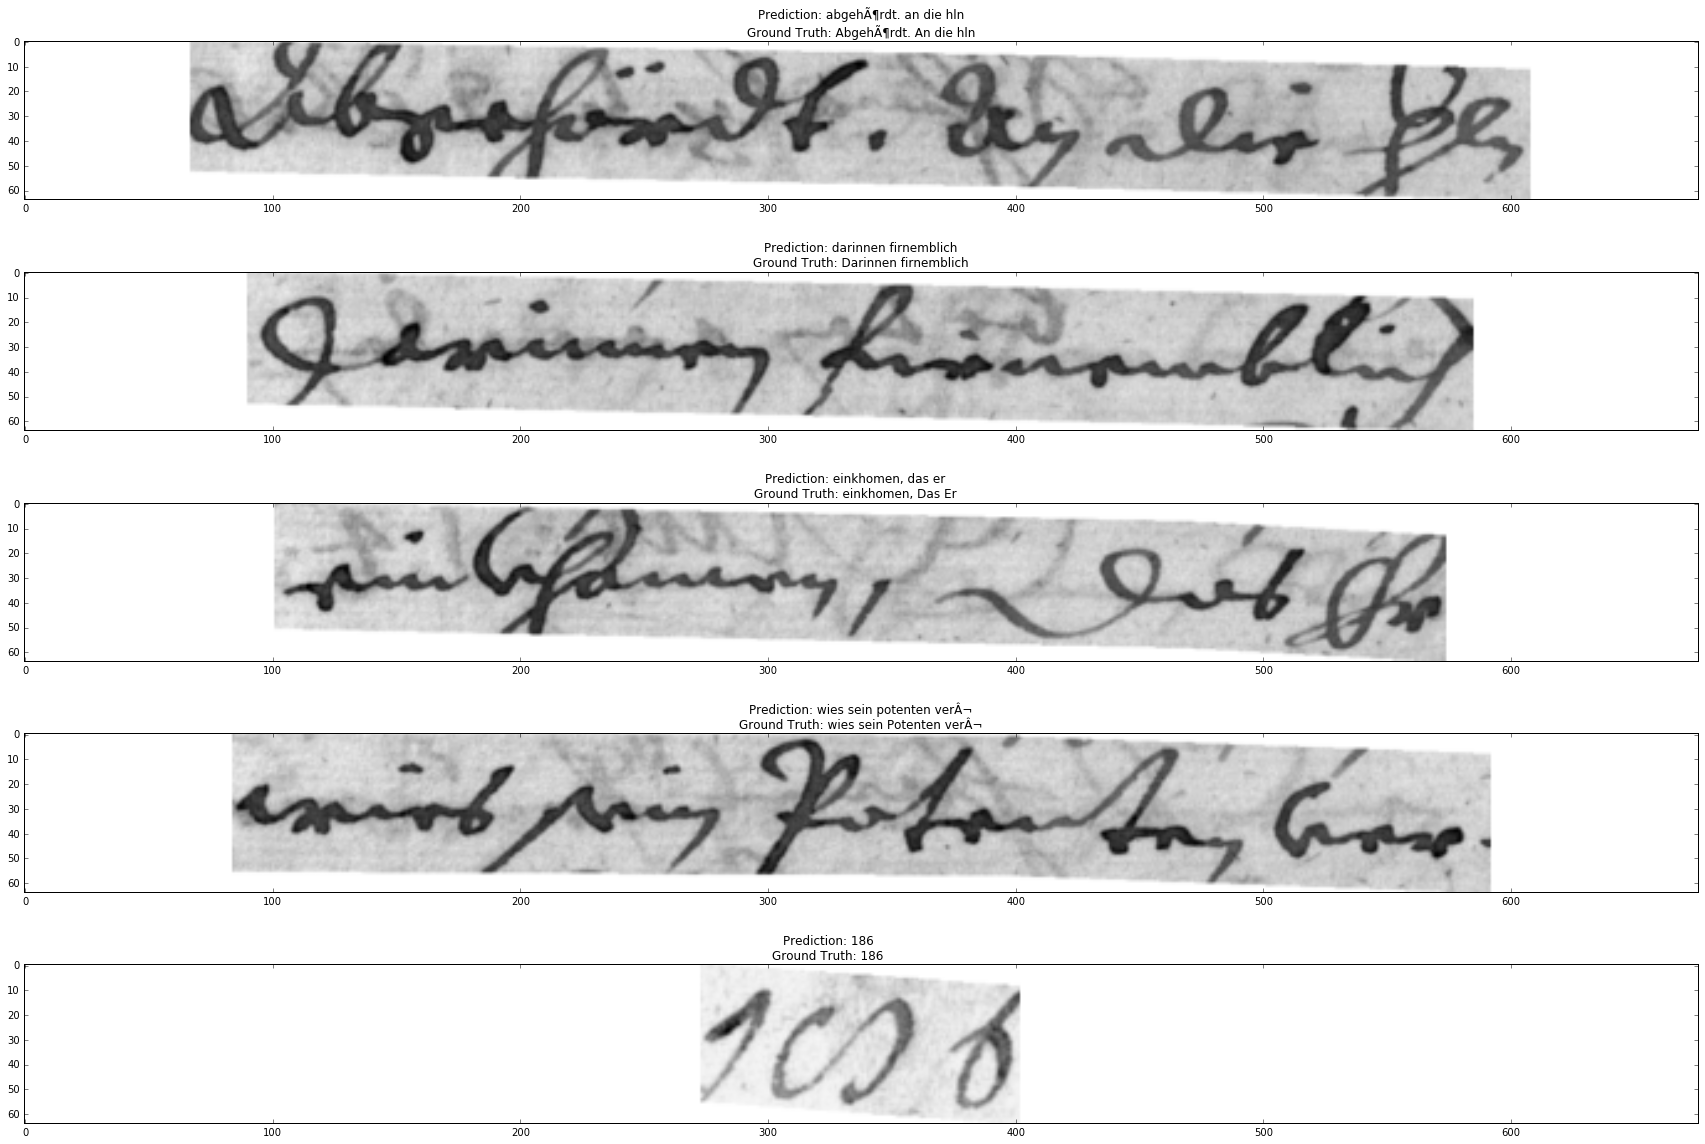

Got through all the sorting in plots_best


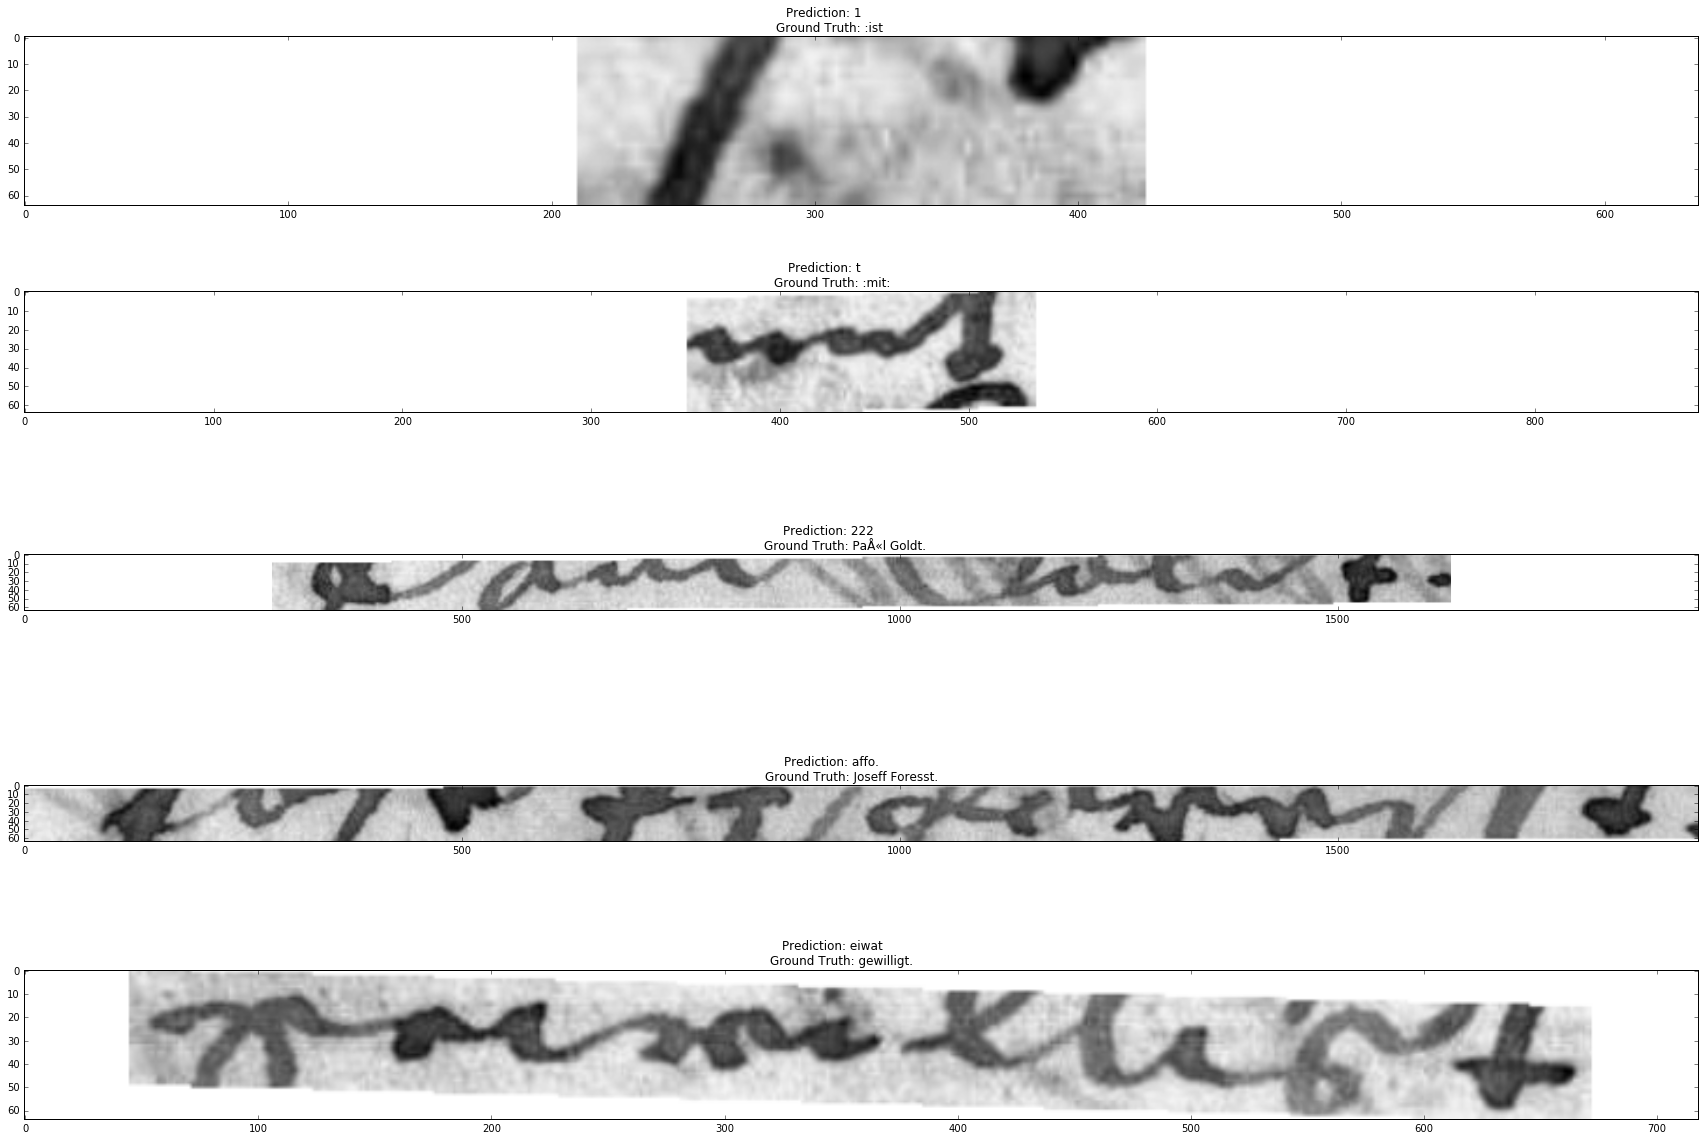

Got through all the sorting in plots_best


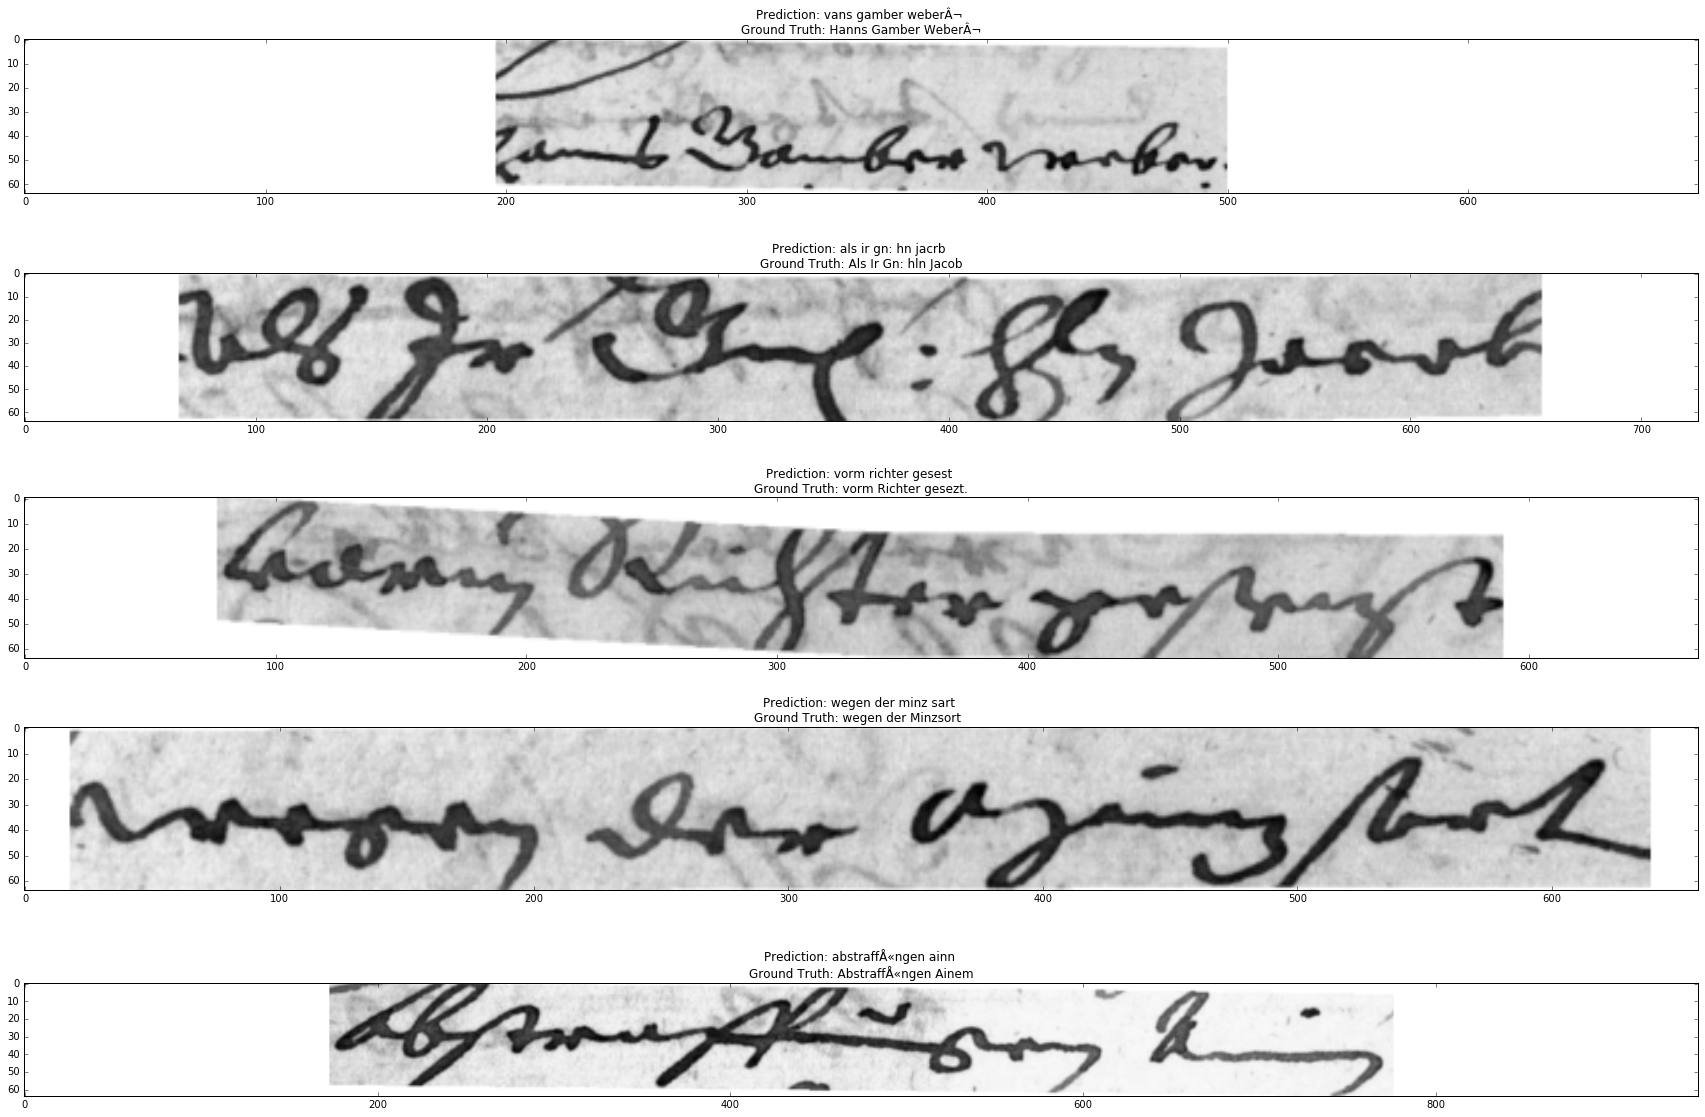

1

In [22]:
# Validation set pictures
# char_error, w_error, all_images, all_preds, all_gts = val(crnn, test_loader, criterion)

# Plot 5 of the best pictures by character error rate
plots_extreme(char_error, w_error, all_images, all_preds, all_gts, n=5, err="char", best=True, median=False) 

# # Plot 5 of the worst pictures
plots_extreme(char_error, w_error, all_images, all_preds, all_gts, n=5, err="char", best=False, median=False)

# # Plot 5 pictures around the median performance
plots_extreme(char_error, w_error, all_images, all_preds, all_gts, n=5, err="char", best=True, median=True) 

In [19]:
# Training set pictures
char_error, w_error, all_images, all_preds, all_gts = val(crnn, train_loader, criterion)

# Plot 5 of the best pictures by character error rate
plots_extreme(char_error, w_error, all_images, all_preds, all_gts, n=5, err="char", best=True, median=False) 

# Plot 5 of the worst pictures
plots_extreme(char_error, w_error, all_images, all_preds, all_gts, n=5, err="char", best=False, median=False)

# Plot 5 pictures around the median performance
plots_extreme(char_error, w_error, all_images, all_preds, all_gts, n=5, err="char", best=True, median=True)

Start val


KeyboardInterrupt: 

In [ ]:
# 800 is an expected overfit model
expect_overfit = "/home/ubuntu/russell/nephi/expr_test_keepaspect_3000/netCRNN_800_131.pth"
# 780 is expected to not overfit as much
expect_great = "/home/ubuntu/russell/nephi/expr_test_keepaspect_3000/netCRNN_780_131.pth"

very_overfit = "/home/ubuntu/russell/nephi/expr_test_keepaspect_3000/netCRNN_850_131.pth"
# we'll see how we do

pre_trained_model = very_overfit
print('loading pretrained model from %s' % pre_trained_model)
crnn.load_state_dict(torch.load(pre_trained_model))

In [ ]:
# Training set pictures
char_error, w_error, all_images, all_preds, all_gts = val(crnn, train_loader, criterion)

# Plot 5 of the best pictures by character error rate
plots_extreme(char_error, w_error, all_images, all_preds, all_gts, n=5, err="char", best=True, median=False) 

# Plot 5 of the worst pictures
plots_extreme(char_error, w_error, all_images, all_preds, all_gts, n=5, err="char", best=False, median=False)

# Plot 5 pictures around the median performance
plots_extreme(char_error, w_error, all_images, all_preds, all_gts, n=5, err="char", best=True, median=True)

In [ ]:
resized_model = "/home/ubuntu/russell/nephi/expr_test_64h/netCRNN_260_262.pth"
pre_trained_model = resized_model
print('loading pretrained model from %s' % pre_trained_model)
crnn.load_state_dict(torch.load(pre_trained_model))

In [ ]:
# Validation set pictures
char_error, w_error, all_images, all_preds, all_gts = val(crnn, test_loader, criterion)

# Plot 5 of the best pictures by character error rate
plots_extreme(char_error, w_error, all_images, all_preds, all_gts, n=5, err="char", best=True, median=False) 

# # Plot 5 of the worst pictures
plots_extreme(char_error, w_error, all_images, all_preds, all_gts, n=5, err="char", best=False, median=False)

# # Plot 5 pictures around the median performance
plots_extreme(char_error, w_error, all_images, all_preds, all_gts, n=5, err="char", best=True, median=True) 

In [ ]:
# Training set pictures
char_error, w_error, all_images, all_preds, all_gts = val(crnn, train_loader, criterion)

# Plot 5 of the best pictures by character error rate
plots_extreme(char_error, w_error, all_images, all_preds, all_gts, n=5, err="char", best=True, median=False) 

# Plot 5 of the worst pictures
plots_extreme(char_error, w_error, all_images, all_preds, all_gts, n=5, err="char", best=False, median=False)

# Plot 5 pictures around the median performance
plots_extreme(char_error, w_error, all_images, all_preds, all_gts, n=5, err="char", best=True, median=True)